In [3]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import linalg as LA
from scipy import linalg as sLA

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append("../scripts")

from State import *

In [6]:
# dt = 0.1
# n = 1
# U = 1

# np.max(get_U(Ham1,t,dt, Trotter = False, n = n) - get_U(Ham1,t,dt, Trotter = True, n = n))

In [53]:

# Возвращает гамильтониан из 1-го упражнения в виде списка матриц пацли, расширенных до размерности 
# 7 кубитов с помощью Кронекеровского произведения с еденичными матрицами

def Ham1(n=7):
          
    H = [X(0,n), X(1,n), X(2,n), X(3,n), X(4,n), X(5,n), X(6,n),
    4*np.dot(X(0,n),Z(2,n)), 9*np.dot(Z(1,n),X(6,n)), 
    9*np.dot(X(3,n),X(4,n)), 13*np.dot(Z(5,n),Z(6,n))]
    return H

# Возвращает унитарное преобразование, соотвтсвующее заданному Гамильтониану;
# При Trotter = True производит трттеризацию с делением на n отрезков (преобразование U составляется из 
# произведениия одно- и двух- кубитных преобразований)

def get_U(Ham,t,dt, Trotter = False, n = 10):
    
    U = 1
    if Trotter == False:
        U = sLA.expm(-1j*sum(Ham())*t)
    
    elif Trotter == True:
        for H in copy.deepcopy(Ham()):
            U = np.dot(U,sLA.expm(-1j*H*t/n))
        U = np.linalg.matrix_power(U, n) 
        
    return U

# Возвращает частичный след по выбранной подсистеме

def partial_trace(rho0, na, nb, system = 'A'):
    
    rho = copy.deepcopy(rho0)

    
    d = int(2**na)
    k = int(2**nb)
        
    rho = np.reshape(rho, (d,k,d,k))
    rho_A = np.trace(rho, axis1=1, axis2=3)
    rho_B = np.trace(rho, axis1=0, axis2=2)
    
    if system == 'A':
        return rho_A
    else:
        return rho_B
    return 0
    
# Возвращает чистоту состояния
def get_purity(rho):
    purity = np.trace(np.dot(rho,rho))
    return purity

# Возвращает Fidelity
def F(rho1, rho2):
    return np.abs(np.trace(sLA.sqrtm(sLA.sqrtm(rho1) @ rho2 @ sLA.sqrtm(rho1))))**2

# Эволюция состояния
# В случае Trotter = True, расчёты проводятся через тротntризованный гамильтониан
# В случае echo = True, в момент времени T2 X гейт действует на первый кубит состояния
def Evolution(rho0, Ham, dt,t0 = 0, t1 = 0.5, Trotter = False, n = 10, echo = False, T2 = 0):
    
    t_list = []
    rho_list = []
    purity_list = []
    rho_A_list = []
    

    rho = copy.copy(rho0)
    
    rho = rho0.copy()
    rho_list.append(rho)
#     print(rho.shape, len(rho), int(np.log2(len(rho)))-1)
    rho_A = partial_trace(rho, 1, int(np.log2(len(rho)))-1)
    purity_list.append(get_purity(rho_A))
    t_list.append(t0)

    t = t0
    

    

    while t <= t1:
        
        U = get_U(Ham,t,dt, Trotter = Trotter, n = n)
        
        if ((echo == True) & (t>T2)):
            U = get_U(Ham,T2,dt, Trotter = Trotter, n = n)
            rho1 = np.dot(np.dot(U,rho), U.conj().T)
            rho1 = np.dot(np.dot(X(0,int(np.log2(len(rho)))),rho1), X(0, int(np.log2(len(rho)))).conj().T)
            U = get_U(Ham,t - T2,dt, Trotter = Trotter, n = n)
            rho1 = np.dot(np.dot(U,rho1), U.conj().T)
            
        else:
            rho1 = np.dot(np.dot(U,rho), U.conj().T)
            
        t += dt
        t_list.append(t)
        rho_list.append(rho1)
        rho_A = partial_trace(rho1, 1, int(np.log2(len(rho1))) - 1)
        rho_A_list.append(rho_A)
        purity_list.append(get_purity(rho_A))
        
    
        
    return t_list, purity_list, rho_list, rho_A_list

In [54]:
# Зададим случайное состояние, где первый кубит не запутан с остальными

n = 7

np.random.seed(2)

state0 = Qpsi(1)
state1 = Qpsi(n-1)
state = Qpsi(n)
state0.build_random_state()
state1.build_random_state()

state.set_coefs(np.kron(state0.get_coefs(),state1.get_coefs()))
# state.build_random_state()
state.split_system(1,n-1)
state.get_coefs()

array([-0.07127281+0.13166116j, -0.01967242+0.07464099j,
       -0.03748091+0.0663044j ,  0.01839285+0.09608548j,
       -0.00241964+0.05547291j, -0.01922369+0.06293512j,
       -0.03722404+0.14053399j, -0.03477759+0.12215289j,
       -0.02988856+0.04775959j,  0.04326017+0.05747141j,
       -0.07142536+0.08961764j,  0.0387831 +0.10959047j,
        0.01038761+0.14438113j,  0.0402023 +0.05644029j,
        0.0010196 +0.1504869j , -0.0355805 +0.04245669j,
       -0.01056508+0.09867677j, -0.03983373+0.04326417j,
       -0.00123775+0.07749489j, -0.05204195+0.05853172j,
       -0.09566219+0.09860546j,  0.03955343+0.07527507j,
       -0.01469792+0.05205084j,  0.00472056+0.01536873j,
       -0.06183173+0.08841788j, -0.04168854+0.09558775j,
        0.01715854+0.06999174j, -0.02816286+0.05839403j,
       -0.01490454+0.12627447j, -0.03052996+0.11054971j,
        0.02526126+0.07025747j, -0.06305107+0.11915703j,
       -0.01628925+0.15475789j,  0.03577353+0.07528137j,
       -0.08119667+0.09341124j,

In [55]:
# Проверим, что первый кубит не запутан с остальными ( purity = 1)

rho0 = state.get_A_rho()
rho_init = state.get_rho()
rho0, get_purity(rho0)

(array([[0.72130969+0.j        , 0.36721098-0.25725109j],
        [0.36721098+0.25725109j, 0.27869031+0.j        ]]),
 (1.0000000000000002+0j))

In [56]:
rho_init.shape

(128, 128)

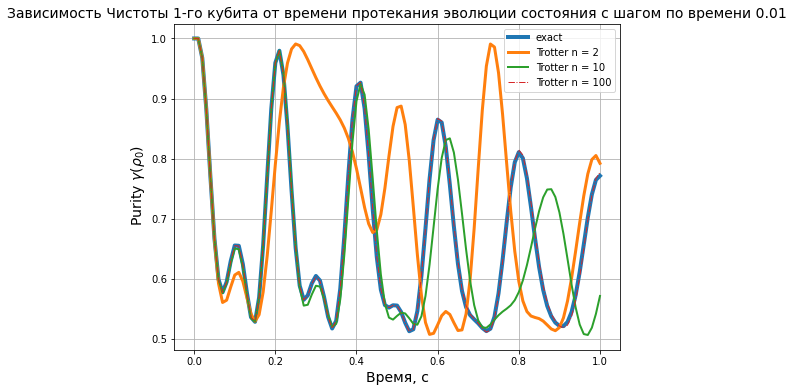

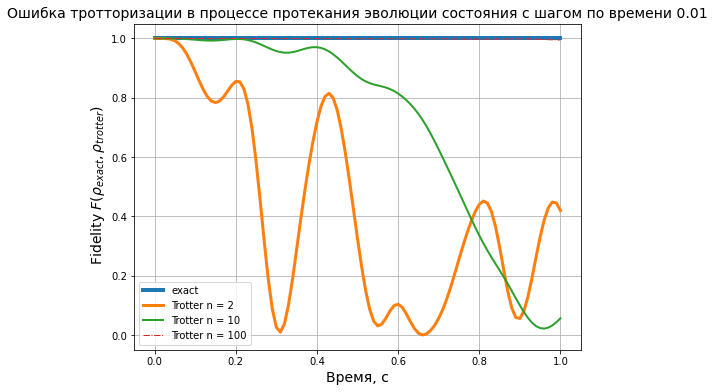

In [57]:
# Проведём необходимые расчёты для полного преобразования и троттеризированного

for dt in [0.01]:
    t, purity, rho_list, _ = Evolution(rho_init, Ham1, dt = dt,t0 = 0, t1 = 1)
    t, purity_trotter2, rho_list2, _ = Evolution(rho_init, Ham1, dt = dt,t0 = 0, t1 = 1, Trotter = True, n = 2)
    t, purity_trotter10, rho_list10, _ = Evolution(rho_init, Ham1, dt = dt,t0 = 0, t1 = 1, Trotter = True, n = 10)
    t, purity_trotter100, rho_list100, _ = Evolution(rho_init, Ham1, dt = dt,t0 = 0, t1 = 1, Trotter = True, n = 100)
    
    fig, ax = plt.subplots(figsize = (8,6))
    ax.set_title(f'Зависимость Чистоты 1-го кубита от времени протекания эволюции состояния c шагом по времени {dt}', fontsize = 14)
    ax.plot(t, purity, label = r'exact', linewidth = 4)
    ax.plot(t, purity_trotter2, label = r'Trotter n = 2', linewidth = 3)
    ax.plot(t, purity_trotter10, label = r'Trotter n = 10', linewidth = 2)
    ax.plot(t, purity_trotter100, label = r'Trotter n = 100', linewidth = 1, linestyle = '-.')
    plt.grid()
    plt.xlabel(r'Время, c', fontsize = 14)
    plt.ylabel(r' Purity $\gamma(\rho_{0})$', fontsize = 14)
    plt.legend()
    plt.show()
    
    F0 = []
    F2 = []
    F10 = []
    F100 = []
    
    for rho, rho2, rho10, rho100 in zip(rho_list, rho_list2, rho_list10, rho_list100):
        F0.append(F(rho, rho))
        F2.append(F(rho, rho2))
        F10.append(F(rho, rho10))
        F100.append(F(rho, rho100))
    
    fig, ax = plt.subplots(figsize = (8,6))
    ax.set_title(f'Ошибка тротторизации в процессе протекания эволюции состояния с шагом по времени {dt}', fontsize = 14)
    ax.plot(t, F0, label = r'exact', linewidth = 4)
    ax.plot(t, F2, label = r'Trotter n = 2', linewidth = 3)
    ax.plot(t, F10, label = r'Trotter n = 10', linewidth = 2)
    ax.plot(t, F100, label = r'Trotter n = 100', linewidth = 1, linestyle = '-.')
    plt.grid()
    plt.xlabel(r'Время, c', fontsize = 14)
    plt.ylabel(r' Fidelity $F(\rho_{exact}, \rho_{trotter} )$', fontsize = 14)
    plt.legend()
    plt.show()

# 5.2. Эффект спинового эха

In [46]:
# Возвращает гамильтониан в виде списка составляющих матриц Паули
def Ham2(n=4):
    H = [Z(0,n), Z(1,n), Z(2,n), Z(3,n),
    4*np.dot(Z(0,n),Z(1,n)),9*np.dot(Z(0,n),Z(2,n)),
    16*np.dot(Z(0,n),Z(3,n))]
    return H

In [47]:
# Зададим случайное состояние, где первый кубит не запутан с остальными
n = 4

np.random.seed(2)

state0 = Qpsi(1)
state1 = Qpsi(n-1)
state = Qpsi(n)
state0.build_random_state()
state1.build_random_state()

state.set_coefs(np.kron(state0.get_coefs(),state1.get_coefs()))
state.split_system(1,n-1)
state.get_coefs()

rho0 = state.get_A_rho()
rho_init = state.get_rho()
rho0, get_purity(rho0)

(array([[0.72130969+0.j        , 0.36721098-0.25725109j],
        [0.36721098+0.25725109j, 0.27869031+0.j        ]]),
 (1.0000000000000004+0j))

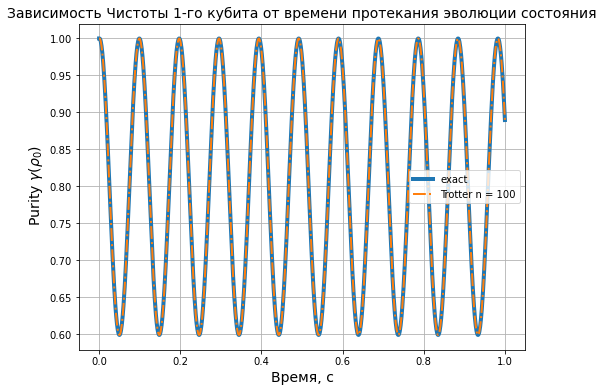

In [48]:
# Проведём эволюцию на временном интервале [0,1]
dt = 0.001

t, purity100, rho_list100, rho_A_list100 = Evolution(rho_init, Ham2, dt = dt,t0 = 0, t1 = 1, Trotter = True, n = 100)
t, purity, rho_list, rho_A_list = Evolution(rho_init, Ham2, dt = dt,t0 = 0, t1 = 1)

fig, ax = plt.subplots(figsize = (8,6))
ax.set_title(r'Зависимость Чистоты 1-го кубита от времени протекания эволюции состояния'.format(dt), fontsize = 14)
ax.plot(t, purity, label = r'exact', linewidth = 4)
ax.plot(t,purity100, label = r'Trotter n = 100', linewidth = 2, linestyle = '-.')
plt.grid()
plt.xlabel(r'Время, c', fontsize = 14)
plt.ylabel(r' Purity $\gamma(\rho_{0})$', fontsize = 14)
plt.legend()
plt.show()

In [49]:
# Найдём время релаксации T2
rho_A_array = np.array(rho_A_list)
b = (np.abs(rho_A_array[0])/np.abs(rho_A_array)-np.exp(1))
b = np.transpose(b, (2,1,0))
# Теперь b[0][1] - массив элементов, описывающих релаксацию состояния в процессе эволюции
print('Для проверки выведем сумму разности двух антидиагональных элементов массива')
print(sum(b[0][1] - b[1][0]))

ind = np.argmax(b[0][1]>0)
print(ind)
T2 = t[ind]
print()
print('T2 = ', T2)
print()
print(np.abs(rho_A_array[0])/np.abs(rho_A_array[ind]) - np.exp(1))

Для проверки выведем сумму разности двух антидиагональных элементов массива
-7.37188088351104e-14
38

T2 =  0.03800000000000003

[[-1.71828183  0.13214527]
 [ 0.13214527 -1.71828183]]


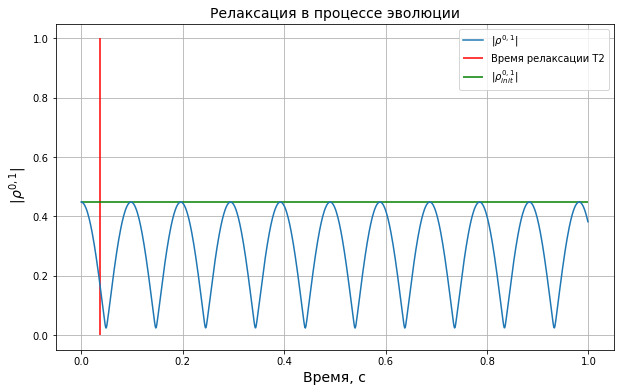

In [50]:
plt.figure(figsize = (10,6))
plt.plot(t[:-1], np.abs(np.transpose(rho_A_array, (2,1,0)))[0][1], label = r'$|\rho^{0,1}|$')
plt.title(r'Релаксация в процессе эволюции'.format(dt), fontsize = 14)
plt.xlabel(r'Время, c', fontsize = 14)
plt.ylabel(r' $|\rho^{0,1}|$', fontsize = 14)
plt.vlines(x = T2, ymin = 0, ymax = 1, color = 'r', label = 'Время релаксации T2')
plt.hlines(y = np.abs(rho_A_array[0][0][1]), xmin = 0, xmax = 1, color = 'g', label = r'$|\rho^{0,1}_{init}|$')
plt.legend()
plt.grid()
plt.show()

/home/stas/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


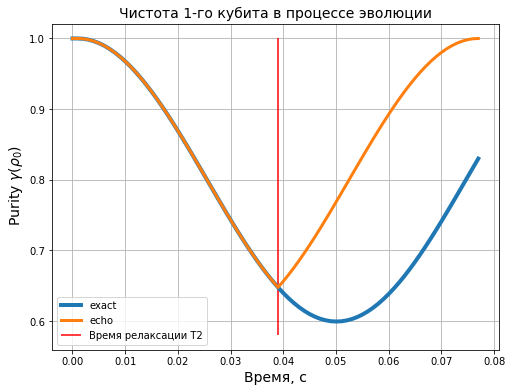

In [51]:

t, purity, rho_list, rho_A_list = Evolution(rho_init, Ham2, dt,t0 = 0, t1 = 2*T2, echo = False, T2 = T2)
t, purity_echo, rho_list, rho_A_list = Evolution(rho_init, Ham2, dt,t0 = 0, t1 = 2*T2, echo = True, T2 = T2)

fig, ax = plt.subplots(figsize = (8,6))
ax.set_title(r'Чистота 1-го кубита в процессе эволюции'.format(dt), fontsize = 14)
ax.plot(t, purity, label = r'exact', linewidth = 4)
ax.plot(t, purity_echo, label = r'echo', linewidth = 3)
plt.grid()
plt.xlabel(r'Время, c', fontsize = 14)
plt.ylabel(r' Purity $\gamma(\rho_{0})$', fontsize = 14)
plt.vlines(x = T2+dt, ymin = 0.58, ymax = 1, color = 'r', label = 'Время релаксации T2')
plt.legend()
plt.show()

In [52]:
# Сравним Purity в начальный и конечный момент:
print('Спиновое эхо: ', purity_echo[-1]/purity_echo[0])
print('Без спинового эхо: ', purity[-1]/purity[0])


Спиновое эхо:  (1.0000000000000002-8.32667268468867e-17j)
Без спинового эхо:  (0.8298026769761324+2.0816681711721676e-17j)
